In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import numpy as np

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
6,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
3,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,fix_linear_regression_standard
2,pretrained_ori,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
0,toy_ori,linear_regression,Transformer,,-1,-1,5,12,8,linear_regression_toy
1,toy_w1_0.9,linear_regression,Transformer,,-1,-1,5,12,8,linear_regression_toy
4,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
5,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained


In [3]:
task = "linear_regression"
#task = "sparse_linear_regression"
# task = "decision_tree"
#task = "relu_2nn_regression"

run_id = "pretrained"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

run_name: fix_linear_regression_standard, id: pretrained
------------------------
conf: Munch({'config': 'conf/fix_linear_regression.yaml', 'inherit': ['/projects/p32013/in-context-learning-fork/src/conf/base.yaml'], 'model': Munch({'family': 'gpt2', 'n_dims': 20, 'n_embd': 256, 'n_head': 8, 'n_layer': 12, 'n_positions': 51}), 'out_dir': '../models/linear_regression/975c42dc-6dba-4c05-b1c8-b7c03b6dbe16', 'test_run': False, 'training': Munch({'batch_size': 64, 'curriculum': Munch({'dims': Munch({'end': 20, 'inc': 1, 'interval': 2000, 'start': 20}), 'points': Munch({'end': 51, 'inc': 2, 'interval': 2000, 'start': 51})}), 'data': 'gaussian', 'keep_every_steps': 100000, 'learning_rate': 0.0001, 'num_tasks': None, 'num_training_examples': None, 'resume_id': None, 'save_every_steps': 1000, 'task': 'linear_regression', 'task_kwargs': Munch({}), 'train_steps': 500001}), 'wandb': Munch({'entity': 'northwestern-in-context-learning', 'log_every_steps': 100, 'name': 'fix_linear_regression_standard

100%|██████████| 15/15 [00:00<00:00, 158076.78it/s]

------------------------
metrics: {'standard': {'gpt2_embd=256_layer=12_head=8': {'mean': [72.56257629394531, 26.977407455444336, 21.43680763244629, 18.401348114013672, 16.98230743408203, 14.075239181518555, 12.79491138458252, 11.932973861694336, 11.131256103515625, 9.515772819519043, 9.305810928344727, 7.705479621887207, 7.365296363830566, 5.9909987449646, 5.39870023727417, 4.540762424468994, 3.51741099357605, 2.7639248371124268, 1.6477391719818115, 1.0872313976287842, 0.51105135679245, 0.25794461369514465, 0.10818812996149063, 0.07829917967319489, 0.05332283303141594, 0.043255072087049484, 0.028053829446434975, 0.023419693112373352, 0.02199099399149418, 0.01950276456773281, 0.017186997458338737, 0.01499507762491703, 0.013338503427803516, 0.013802086934447289, 0.012768125161528587, 0.012837402522563934, 0.012271126732230186, 0.013058038428425789, 0.010309455916285515, 0.011438155546784401, 0.010440532118082047, 0.009572025388479233, 0.010029591619968414, 0.009751226752996445, 0.009892

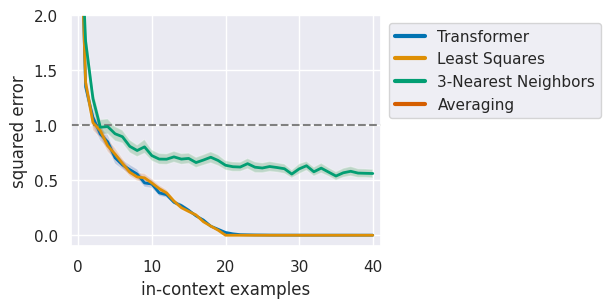

In [4]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [6]:
from samplers import get_data_sampler
from tasks import get_task_sampler
print(conf.training.curriculum.points.end)

51


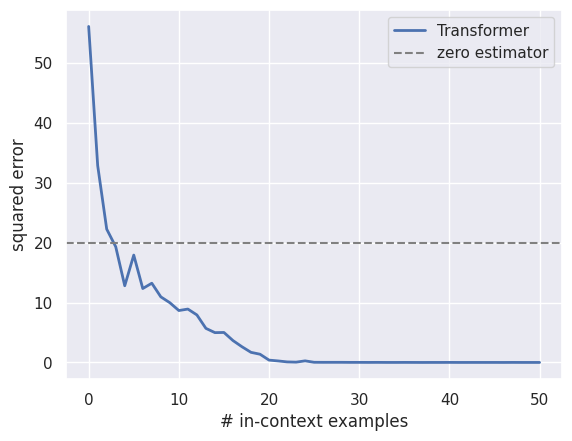

In [7]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size
data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)
with torch.no_grad():
    pred = model(xs, ys)
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

### 4.1 Sample Selection / Covariate Shifts

####  Part 1 - Sample Selection: W1 = 0.9, w2 = 0.1

In [8]:
n_batches = 1000
prompt_length = 2*conf.training.curriculum.points.end-1

all_errors_w1_9 = []
# save xs and ys for the 4.2 experiment
xs_list = [] 
ys_list = [] 
# Generate data and perform the experiment
for _ in range(n_batches):

    xs = data_sampler.sample_xs(b_size=batch_size, n_points=prompt_length)
    xs_list.append(xs)
    ys = task.evaluate(xs)
    ys_list.append(ys)

    with torch.no_grad():
        pred = model(xs, ys)
        
    metric = task.get_metric()
    loss = metric(pred, ys).numpy()
    all_errors_w1_9.append(loss)

mean_errors_w1_9 = np.mean(all_errors_w1_9, axis=(0, 1))


KeyboardInterrupt: 

In [ ]:
print(len(all_errors_w1_9))
print(len(all_errors_w1_9[0]))
print(len(all_errors_w1_9[0][0]))

100
64
101


####  Part 2 - Covariate Shifts

##### W1 = 0.8, w2 = 0

In [ ]:
all_errors_w1_8 = []
for _ in range(n_batches):

    xs = data_sampler.sample_xs(b_size=batch_size, n_points=prompt_length, w1=0.8, w2=0)
    ys = task.evaluate(xs)

    with torch.no_grad():
        pred = model(xs, ys)
        
    metric = task.get_metric()
    loss = metric(pred, ys).numpy()
    all_errors_w1_8.append(loss)

mean_errors_w1_8 = np.mean(all_errors_w1_8, axis=(0, 1))



##### W1 = 0, w2 = 0.8

In [14]:
all_errors_w1_0 = []
for _ in range(n_batches):

    xs = data_sampler.sample_xs(b_size=batch_size, n_points=prompt_length, w1=0, w2=0.8)
    ys = task.evaluate(xs)

    with torch.no_grad():
        pred = model(xs, ys)
        
    metric = task.get_metric()
    loss = metric(pred, ys).numpy()
    all_errors_w1_0.append(loss)

mean_errors_w1_0 = np.mean(all_errors_w1_0, axis=(0, 1))


##### W1 = 0.1, w2 = 0.9

In [15]:
all_errors_w1_1 = []

for _ in range(n_batches):

    xs = data_sampler.sample_xs(b_size=batch_size, n_points=prompt_length, w1=0.1, w2=0.9)
    ys = task.evaluate(xs)

    with torch.no_grad():
        pred = model(xs, ys)
        
    metric = task.get_metric()
    loss = metric(pred, ys).numpy()
    all_errors_w1_1.append(loss)

mean_errors_w1_1 = np.mean(all_errors_w1_1, axis=(0, 1))


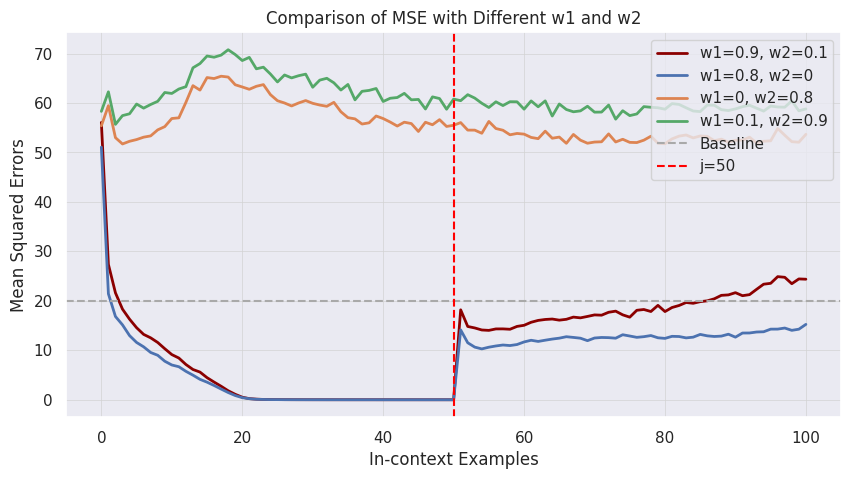

In [ ]:

plt.figure(figsize=(10, 5), facecolor='none')
plt.plot(range(prompt_length), mean_errors_w1_9, label='w1=0.9, w2=0.1', color='darkred', linewidth=2)
plt.plot(range(prompt_length), mean_errors_w1_8, label='w1=0.8, w2=0', linewidth=2)
# plt.plot(range(prompt_length), mean_errors_w1_0, label='w1=0, w2=0.8', linewidth=2)
# plt.plot(range(prompt_length), mean_errors_w1_1, label='w1=0.1, w2=0.9', linewidth=2)

plt.axhline(baseline, ls="--", color="darkgray", label="Baseline")
plt.axvline(x=50, color="red", linestyle="--", label="j=50")
existing_ticks = plt.xticks()[0]
new_ticks = sorted(set(existing_ticks).union({50}))
plt.xticks(new_ticks)
# Adding legend, labels, and title
plt.legend(loc="upper right")
plt.xlabel('In-context Examples')
plt.ylabel('Mean Squared Errors')
plt.title('Comparison of MSE with Different w1 and w2')

plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
# plt.savefig("../output/4.1_test_Sample_Selection_Covariate_Shifts.pdf", bbox_inches='tight', transparent=True)
# Show the plot
plt.show()

#### 4.2 Sensitivity to Label Format: second part <strong>Linear regression with random labels<strong>

In [29]:
all_errors_random_labels = []
# Generate data and perform the experiment
for batch in range(n_batches):

    xs = xs_list[batch]
    ys = ys_list[batch]

    batch_errors = []
    # j's idx starts at 1, but in graph, we refer it to 0
    for j in range(1, prompt_length+1):
        permuted_ys = np.copy(ys)
        if j > 2:  # if j == 1, 2, there are no prior labels or no need to permuted
            for i in range(batch_size):
                np.random.shuffle(permuted_ys[i, :j-1])
        
        # Transfer np array to tensor
        permuted_ys_tensor = torch.from_numpy(permuted_ys)
        # predict with the si
        with torch.no_grad():
            pred = model(xs, permuted_ys_tensor)

        metric = task.get_metric()
        loss = metric(pred[:, j-1], ys[:, j-1]).numpy() 
        batch_errors.append(loss)

    # Store the mean error across all samples in the batch for each j
    # all_errors_random_labels's size is (100,21,64)
    all_errors_random_labels.append(batch_errors)



In [ ]:
mean_errors_random_labels = np.mean(all_errors_random_labels, axis=(0, 2))

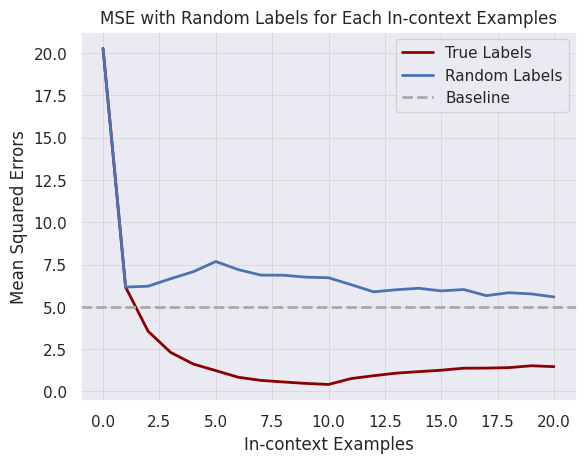

In [ ]:

plt.plot(range(prompt_length), mean_errors_w1_9, label="True Labels",color='darkred', linewidth=2)
plt.plot(range(prompt_length), mean_errors_random_labels, label="Random Labels", linewidth=2)
plt.axhline(baseline, ls="--", color="darkgray", label="Baseline", linewidth=2)
existing_ticks = plt.xticks()[0]
new_ticks = sorted(set(existing_ticks).union({50}))
plt.xticks(new_ticks)
plt.legend()
plt.xlabel('In-context Examples')
plt.ylabel('Mean Squared Errors')
plt.title('MSE with Random Labels for Each In-context Examples')
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.savefig("../output/4.2_Std_Sensitivity_to_Label_Format.pdf", bbox_inches = "tight", transparent=True)
plt.show()